## Sequential CNN autoencoder + classification - joint training


In [5]:
%matplotlib inline
import os
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization,\
                         Flatten, Dense, Conv2DTranspose, Reshape,MaxPooling2D, \
                         UpSampling2D, Lambda, Dropout, Concatenate
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.utils import class_weight
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import pickle
import random
import collections
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(11)
data_path = "cifar-10-batches-py"

# *Read Data*

In [6]:
def unpickle(file):
    with open(file, 'rb') as fo:
        datadict = pickle.load(fo, encoding='bytes')
    return datadict

In [7]:
label_path = os.path.join(data_path,'batches.meta')
label_dict = unpickle(label_path) 
class_list_b = label_dict[b'label_names']
cut_factor = 0.5
bird = 2
deer = 4
truck = 9
downsample_list = [2,4,9]
class_list=[]
for each in class_list_b:
    class_list.append(each.decode('utf8'))

In [8]:
def load_train_data(data_path):
    for i in range(1,6):
        batch_path = os.path.join(data_path, 'data_batch_' + str(i))
        data_dict = unpickle(batch_path)
        #d =collections.Counter(data_dict[b'labels'])
        #dd = collections.OrderedDict(sorted(d.items(), key=lambda t: t[0]))
        #print(d)
        #print(dd)
        if (i == 1):
            train_data = data_dict[b'data']
            train_labels = data_dict[b'labels']
            
        else:
            train_data = np.vstack((train_data, data_dict[b'data']))
            train_labels += data_dict[b'labels']
    
    
    train_data = train_data.reshape((len(train_data),3,32, 32))
    train_data = train_data.transpose(0, 2, 3, 1)
    train_labels = np.asarray(train_labels)
    
    data_dict = unpickle(data_path+"/test_batch")
    test_data = np.asarray(data_dict[b'data'])
    test_labels = np.asarray(data_dict[b'labels'])
    
    test_data = test_data.reshape((len(test_data), 3, 32, 32))
    test_data = test_data.transpose(0, 2, 3, 1)
    return train_data,train_labels,test_data,test_labels

def downsample_data(downsample_list,Xtrain,Ytrain,cut_factor):
    for i,class_id in enumerate(downsample_list):
        label_idx = [idx for idx, y in enumerate(Ytrain) if y == class_id]
        if (i == 0):
            downsample_ids = random.sample(label_idx,(int)(cut_factor*len(label_idx)))
        else:
            downsample_ids += random.sample(label_idx,(int)(cut_factor*len(label_idx)))
    downsample_ids = sorted(downsample_ids)
    new_Xtrain = np.delete(Xtrain,downsample_ids,axis=0)
    new_Ytrain = np.delete(Ytrain,downsample_ids,axis=0)
    return new_Xtrain,new_Ytrain    

full_Xtrain,full_Ytrain,Xtest,Ytest = load_train_data(data_path)
Xtrain,Ytrain = downsample_data(downsample_list,full_Xtrain,full_Ytrain,cut_factor)
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

class_weights = list(class_weight.compute_class_weight(
               'balanced',
                np.unique(Ytrain), 
                Ytrain.reshape(Ytrain.shape[0])))
print(class_weights)


#d =collections.Counter(new_Ytrain)
#print(collections.OrderedDict(sorted(d.items(), key=lambda t: t[0])))
num_training_imgs = Xtrain.shape[0]
num_test_imgs = Xtest.shape[0]
num_classes = len(np.unique(Ytrain))

print(num_classes,num_training_imgs,num_test_imgs)


(42500, 32, 32, 3)
(42500,)
(10000, 32, 32, 3)
(10000,)
[0.85, 0.85, 1.7, 0.85, 1.7, 0.85, 0.85, 0.85, 0.85, 1.7]
10 42500 10000


In [9]:

Xtrain = Xtrain.astype('float32') / 255.
Xtest = Xtest.astype('float32') / 255.
YtrainHot = keras.utils.to_categorical(Ytrain, num_classes)
YtestHot = keras.utils.to_categorical(Ytest, num_classes)

# # mean-subtraction
# Xtrain_mean = np.mean(Xtrain, axis=(0))
# Xtrain -= Xtrain_mean
# Xtest -= Xtrain_mean

# standardization
# Xtrain_mean = np.mean(Xtrain,axis=(0,1,2))
# std = np.std(Xtrain,axis=(0,1,2))
# Xtrain = Xtrain/(std+1e-7)
# Xtest = Xtest/(std+1e-7)
# print(Xtrain_mean)
# print(std)


num_classes = 10

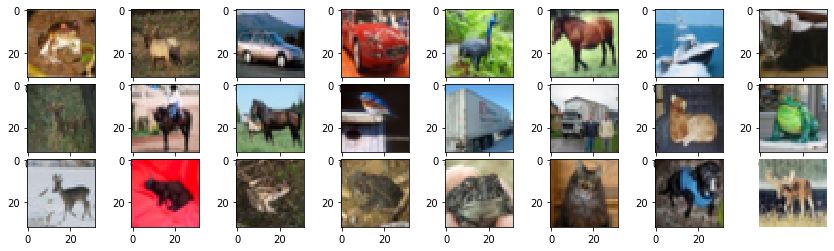

In [5]:
def check_images(images):
    fig = plt.figure(figsize=(15, 4))
    columns = 8
    rows = 3
    for i in range(1, columns*rows+1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1])
    
    fig.subplots_adjust(hspace=0.1)
    fig.subplots_adjust(wspace=0)
    plt.axis('off')
    #plt.tight_layout()
    plt.show()
    
check_images(Xtrain)

# Evaluation functions

In [5]:
def visualize_reconstruction(ip, dec, num=10):
    n = num
    plt.figure(figsize=(20, 4))
    mse = np.mean(((ip.astype("float") - dec.astype("float"))**2),axis=(0,1,2,3))
    print(mse)   
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(ip[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def evaluate_classification(Ytest,Ypred):
    cm=confusion_matrix(Ytest, Ypred)
    print("Classification Report:\n")
    cr=classification_report(Ytest,Ypred,target_names=class_list)
    print(cr)
    plt.figure(figsize=(12,12))
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels = class_list, yticklabels = class_list, fmt="d")

## Joint training

In [47]:
def aec_model():
    
    input_img = Input(shape=(32, 32, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='c1')(input_img)
    conv1 = BatchNormalization()(conv1)
    
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same',name = 'c2')(conv1)
    conv2 = BatchNormalization(name = 'c2bn')(conv2)
    conv2p = MaxPooling2D(pool_size=(2, 2))(conv2) #16
    
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same', name = 'c3')(conv2p)
    conv3 = BatchNormalization()(conv3)
    
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', name = 'c4')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4p = MaxPooling2D(pool_size=(2, 2),name='encoder')(conv4)   #8

    enc_opt = conv4p
    flatten_opt = Flatten(name = 'flatten_enc')(conv4p)
    enc_opt = Reshape((8, 8, 64))(flatten_opt)
    
    #conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4p)
    #conv5 = BatchNormalization()(conv5)
    #enc_opt = conv5
        
    convt6 = Conv2DTranspose(64, kernel_size=2, strides=2)(enc_opt)
    convt6 = BatchNormalization()(convt6)
    #convtcat6 = Concatenate()([convt6, conv4])
    #print(convtcat6)
    convt7 = Conv2DTranspose(32, kernel_size=2, strides=2)(convt6)
    convt7 = BatchNormalization()(convt7)
    #convtcat7 = Concatenate()([convt7, conv2])
    #print(convtcat7)
    conv8 = Conv2D(32,(2,2),activation='relu', padding='same')(convt7)
    
    # reconstruction
    dec_opt = Conv2D(3,(1,1),activation = 'sigmoid',name='decoder')(conv8)
    
    conv= Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', name = 'cb_1')(enc_opt)
    conv = BatchNormalization(name = 'cbn_1')(conv)
    conv = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',name='cb_2')(conv)
    conv = BatchNormalization()(conv)
    conv = MaxPooling2D((2, 2))(conv)
    conv = Dropout(0.2)(conv)
    conv = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',name = 'cb_3')(conv)
    conv = BatchNormalization()(conv)
    conv = MaxPooling2D((2, 2))(conv)
    conv = Dropout(0.2)(conv)
    classification = Flatten()(conv)
    classification = Dense(128, activation='relu', kernel_initializer='he_uniform',
                           activity_regularizer=l2(0.00005))(classification)
    classification = BatchNormalization()(classification)
    classification = Dropout(0.5)(classification)
    classification = Dense(10, activation='softmax',name='classifier')(classification)
                        
    
    return Model(inputs = input_img, outputs = [dec_opt, classification])
    

In [35]:
aec_model = aec_model()

In [48]:
aec_model = aec_model()
aec_model.compile(loss = {'decoder': 'mean_squared_error','classifier': 'categorical_crossentropy'}, 
                  loss_weights = {'decoder': 1.0, 'classifier': 1.0}, 
                  optimizer = Adam(),
                  metrics = {'classifier': ['accuracy'], 'decoder': []})

train_datagen = ImageDataGenerator(shear_range=0.1,rescale=1./255,rotation_range=20, zoom_range=0.2, brightness_range=[0.3,0.7],
                                   width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,
                                   vertical_flip=True, fill_mode="nearest",preprocessing_function=get_random_eraser(v_l=0, v_h=1))

test_datagen = ImageDataGenerator() 


def image_generator(datagen,Xtrain,Ytrain,batchsize):
    gen = datagen.flow(Xtrain, Ytrain, batch_size=batchsize)
    while(True):
        Xtrain_data, Ytrain_data = gen.next()
        yield Xtrain_data, {'decoder': Xtrain_data,'classifier': Ytrain_data}
     
mcp_callback_j = ModelCheckpoint('cmodel-{epoch:03d}-{classifier_acc:03f}-{val_classifier_acc:03f}.h5', verbose=1, monitor='val_classifier_acc',save_best_only=True, mode='auto') 
estop_callback_j = EarlyStopping(monitor='val_classifier_acc', patience=20, min_delta=0.001, restore_best_weights=True)
lrdecay_callback_j = ReduceLROnPlateau(monitor='val_classifier_acc', factor=0.1, patience=10, min_delta=0.005,min_lr=0.00001,verbose=1)
callbacks = [lrdecay_callback_j, estop_callback_j, mcp_callback_j]


# history = aec_model.fit(Xtrain, [Xtrain,YtrainHot], batch_size=batch_size, epochs=200, 
#                           validation_data = (Xtest, [Xtest,YtestHot]),
#                           shuffle=True)
# #                           class_weight=class_weights
batch_size = 64
steps = Xtrain.shape[0]//batch_size

history = aec_model.fit(Xtrain,{'decoder': Xtrain,'classifier': YtrainHot},
        epochs=150,callbacks = callbacks,
        shuffle=True, #class_weight=class_weights,
        validation_data=(Xtest,{'decoder': Xtest,'classifier': YtestHot}))



# history = aec_model.fit_generator(
#         image_generator(train_datagen,Xtrain,YtrainHot,batch_size),
#         steps_per_epoch=steps,
#         epochs=400,
#         shuffle=True, class_weight=class_weights, callbacks=callbacks,
#         validation_data=(Xtest,{'decoder': Xtest,'classifier': YtestHot}))


Train on 42500 samples, validate on 10000 samples
Epoch 1/300
42464/42500 [============================>.] - ETA: 0s - loss: 1.6116 - decoder_loss: 0.0126 - classifier_loss: 1.5471 - classifier_acc: 0.4703
Epoch 00001: val_classifier_acc improved from -inf to 0.45390, saving model to cmodel-001-0.470376-0.453900.h5
42500/42500 [==============================] - 71s 2ms/sample - loss: 1.6115 - decoder_loss: 0.0126 - classifier_loss: 1.5479 - classifier_acc: 0.4704 - val_loss: 1.6810 - val_decoder_loss: 0.0179 - val_classifier_loss: 1.6020 - val_classifier_acc: 0.4539
Epoch 2/300
42496/42500 [============================>.] - ETA: 0s - loss: 1.1820 - decoder_loss: 0.0117 - classifier_loss: 1.1155 - classifier_acc: 0.6136
Epoch 00002: val_classifier_acc improved from 0.45390 to 0.55310, saving model to cmodel-002-0.613671-0.553100.h5
42500/42500 [==============================] - 38s 901us/sample - loss: 1.1820 - decoder_loss: 0.0117 - classifier_loss: 1.1149 - classifier_acc: 0.6137 - va

42464/42500 [============================>.] - ETA: 0s - loss: 0.2587 - decoder_loss: 0.0085 - classifier_loss: 0.2309 - classifier_acc: 0.9227
Epoch 00017: val_classifier_acc improved from 0.80990 to 0.81990, saving model to cmodel-017-0.922659-0.819900.h5
42500/42500 [==============================] - 51s 1ms/sample - loss: 0.2588 - decoder_loss: 0.0085 - classifier_loss: 0.2309 - classifier_acc: 0.9227 - val_loss: 0.6760 - val_decoder_loss: 0.0084 - val_classifier_loss: 0.6476 - val_classifier_acc: 0.8199
Epoch 18/300
42496/42500 [============================>.] - ETA: 0s - loss: 0.2410 - decoder_loss: 0.0086 - classifier_loss: 0.2146 - classifier_acc: 0.9287
Epoch 00018: val_classifier_acc did not improve from 0.81990
42500/42500 [==============================] - 42s 982us/sample - loss: 0.2411 - decoder_loss: 0.0087 - classifier_loss: 0.2152 - classifier_acc: 0.9286 - val_loss: 0.8050 - val_decoder_loss: 0.0092 - val_classifier_loss: 0.7774 - val_classifier_acc: 0.7983
Epoch 19/3

Epoch 49/300
42496/42500 [============================>.] - ETA: 0s - loss: 0.0253 - decoder_loss: 0.0069 - classifier_loss: 0.0134 - classifier_acc: 0.9960- ETA: 4s - loss: 0.0254 - dec
Epoch 00049: val_classifier_acc improved from 0.84580 to 0.84640, saving model to cmodel-049-0.996047-0.846400.h5
42500/42500 [==============================] - 42s 982us/sample - loss: 0.0253 - decoder_loss: 0.0069 - classifier_loss: 0.0134 - classifier_acc: 0.9960 - val_loss: 0.9064 - val_decoder_loss: 0.0063 - val_classifier_loss: 0.8971 - val_classifier_acc: 0.8464
Epoch 50/300
42496/42500 [============================>.] - ETA: 0s - loss: 0.0239 - decoder_loss: 0.0069 - classifier_loss: 0.0120 - classifier_acc: 0.9964
Epoch 00050: val_classifier_acc improved from 0.84640 to 0.84660, saving model to cmodel-050-0.996447-0.846600.h5
42500/42500 [==============================] - 45s 1ms/sample - loss: 0.0239 - decoder_loss: 0.0069 - classifier_loss: 0.0120 - classifier_acc: 0.9964 - val_loss: 0.8993 

Epoch 66/300
42432/42500 [============================>.] - ETA: 0s - loss: 0.0215 - decoder_loss: 0.0069 - classifier_loss: 0.0100 - classifier_acc: 0.9971
Epoch 00066: val_classifier_acc did not improve from 0.84660
42500/42500 [==============================] - 46s 1ms/sample - loss: 0.0217 - decoder_loss: 0.0069 - classifier_loss: 0.0114 - classifier_acc: 0.9970 - val_loss: 0.9251 - val_decoder_loss: 0.0062 - val_classifier_loss: 0.9138 - val_classifier_acc: 0.8452


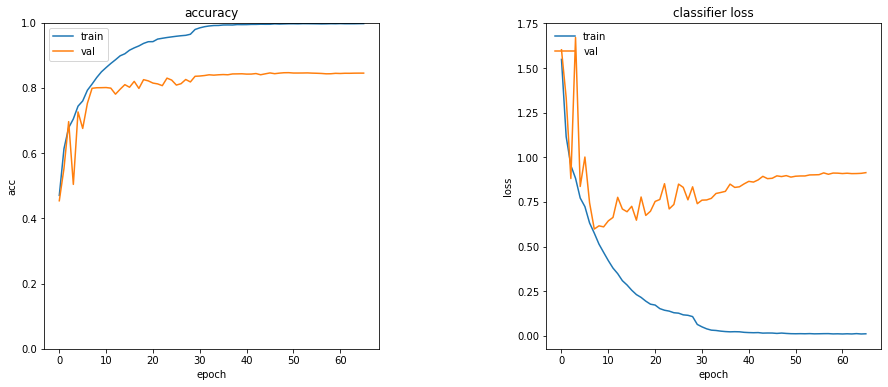

In [49]:
aec_model.save("joint_no_augmentation_early_stopping.h5")

#%tensorboard --logdir logs/
f,ax = plt.subplots(1, 2,figsize=(15,6))
ax[1].plot(history.history['classifier_loss'],label='train')
ax[1].plot(history.history['val_classifier_loss'],label='val')
ax[1].set_title('classifier loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(loc='upper left', frameon=False)

ax[0].plot(history.history['classifier_acc'])
ax[0].plot(history.history['val_classifier_acc'])
ax[0].set_ylim([0,1])
ax[0].set_title('accuracy')
ax[0].set_ylabel('acc')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

f.subplots_adjust(hspace=0.5)
f.subplots_adjust(wspace=0.5)

plt.show()


# YpredsHot = aec_model.predict(Xtest)
# Ypreds = np.argmax(YpredsHot,axis=1)
# evaluate_classification(Ytest,Ypreds)



0.006353775671056395


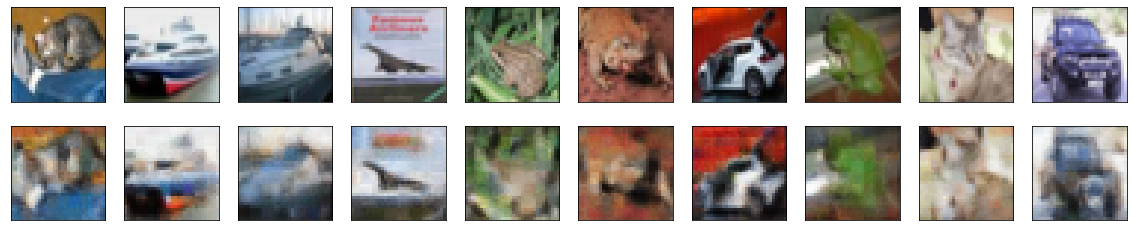

Classification Report:

              precision    recall  f1-score   support

    airplane       0.82      0.90      0.86      1000
  automobile       0.93      0.94      0.93      1000
        bird       0.84      0.69      0.76      1000
         cat       0.72      0.72      0.72      1000
        deer       0.84      0.80      0.82      1000
         dog       0.75      0.81      0.78      1000
        frog       0.83      0.92      0.87      1000
       horse       0.89      0.90      0.89      1000
        ship       0.91      0.92      0.92      1000
       truck       0.94      0.86      0.90      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.84     10000
weighted avg       0.85      0.85      0.84     10000



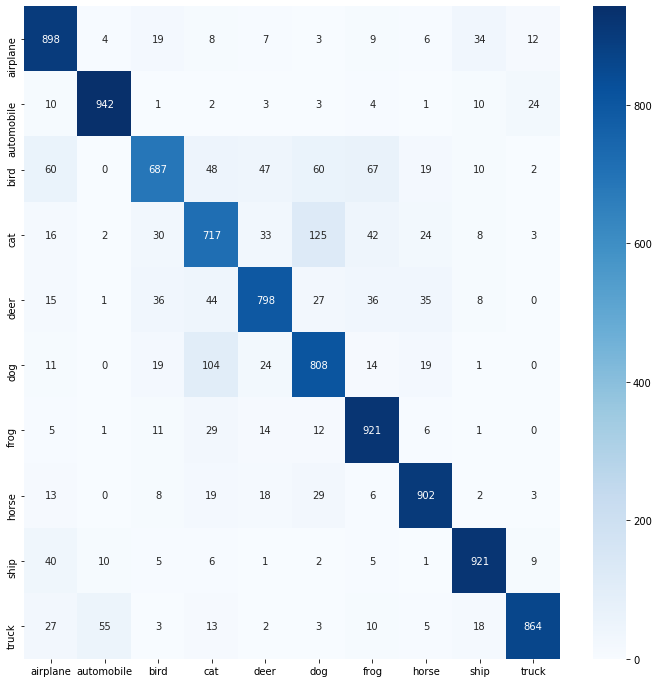

In [50]:
recons_imgs, YpredsHot = aec_model.predict(Xtest)
Ypreds = np.argmax(YpredsHot,axis=1)
visualize_reconstruction(Xtest,recons_imgs)
evaluate_classification(Ytest,Ypreds)

In [54]:
aec_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
c1 (Conv2D)                     (None, 32, 32, 32)   896         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_87 (BatchNo (None, 32, 32, 32)   128         c1[0][0]                         
__________________________________________________________________________________________________
c2 (Conv2D)                     (None, 32, 32, 32)   9248        batch_normalization_87[0][0]     
____________________________________________________________________________________________

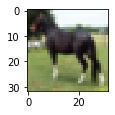

In [107]:
ip_img = Xtest[4100,...]
plt.figure(figsize=(1.5,1.5))
plt.imshow(ip_img)

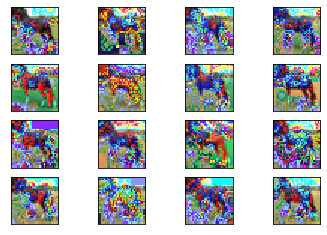

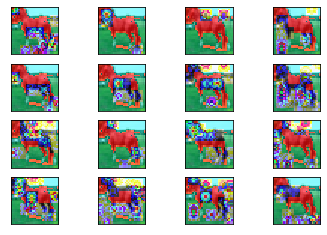

In [108]:
import cv2
ixs = [10,15] #layer indices - encoder layer(name = encoder) and after first layer of classification (name = cbn_1)
img1 = ip_img
img = np.expand_dims(ip_img, axis=0)
outputs = [aec_model.layers[i].output for i in ixs]
model = Model(inputs=aec_model.inputs, outputs=outputs)
feature_maps = model.predict(img)
square = 4
for fmap in feature_maps:
# plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            filter_i= fmap[0, :, :, ix-1]/fmap[0, :, :, ix-1].max()
            #plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
            fmap1 = cv2.resize(filter_i,(32,32))
            fmap1 = cv2.applyColorMap(np.uint8(255 * (255 - fmap1)), cv2.COLORMAP_JET)
            #print(fmap1.shape)
#             for each in range(ip_img.shape[2]):
#                 ip_img[:,:,each] = np.multiply(ip_img[:,:,each],fmap1)
            plt.imshow(((fmap1 * 0.4 + ip_img)*255).astype(np.uint8))
            ix += 1
    # show the figure
    plt.show()
